In [1]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

In [2]:
# load and inspect the data
df = pd.read_csv('data.csv')
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [3]:
# rename the column names for prophet
df[ 'FullDate' ]= pd.to_datetime(df[ 'FullDate' ]) 
df = df.rename(columns={ "FullDate" : "ds" , "ElecPrice" : "y" }) 
df.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [4]:
# resample to data to daily rate
df.set_index( "ds", inplace= True) # resample requires a datetime index
df_daily = df.resample('D').sum()
df_daily.shape

(3834, 4)

In [5]:
# split into train and test sets
df_daily.reset_index(inplace=True)
train = df_daily.iloc[:2757,:]
test = df_daily.iloc[2757:,:]
train.shape,test.shape

((2757, 5), (1077, 5))

## 11. Which of the following is a plot of ElecPrice over time?

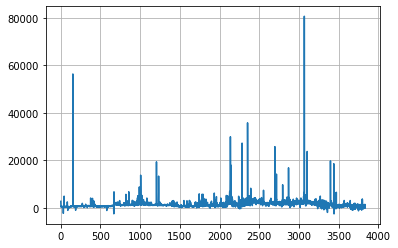

In [6]:
df_daily.y.plot()
plt.grid();

## 12. Using the Augmented Dicky Fuller test (ADF), what is the P-value of the SysLoad and GasPrice of the resampled Data set, to 6 decimal places?

In [7]:
from statsmodels.tsa.stattools import adfuller 
adf_sys = adfuller(df_daily['SysLoad'])
adf_gas = adfuller(df_daily['GasPrice']) 
round(adf_sys[1],6), round(adf_gas[1],6)

(0.004254, 0.045027)

## 13. Using the Augmented Dicky Fuller test (ADF) what are the 10% and 5% critical values of GasPrice and ElecPrice of the resampled Data set, to 4 decimal places?

In [8]:
adf_elec = adfuller(df_daily['y'])
round(adf_gas[4]['10%'],4), round(adf_elec[4]['5%'],4)

(-2.5672, -2.8623)

## 14. Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

In [9]:
# define mape function
def mape(y,yhat):
    # reset index of actual values
    y = y.reset_index(drop=True)
    
    diff = y-yhat
    fractional_diff = diff/y
    abs_value = abs(fractional_diff)
    avg_value = abs_value.mean()
    percentage = avg_value*100
    return round(percentage,2)

In [10]:
# fit univariate time series model
model_1 = Prophet() 
model_1.fit(train)

Initial log joint probability = -4.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8006.42   0.000190736       172.415           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        8007.2    4.4511e-05       55.1814      0.8319      0.8319      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       8007.24   0.000127972       100.748   1.491e-06       0.001      313  LS failed, Hessian reset 
     299       8007.56   3.00801e-05       44.3474      0.5552      0.5552      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       8007.61   4.26709e-05       140.953   1.449e-07       0.001      531  LS failed, Hessian reset 
     399       8007.64   7.42204e-06       64.1818      0.0646           1      606   
    Iter      log pro

In [11]:
# evaluate mape
forecast_1 = model_1.predict(test) 
mape(test['y'],forecast_1['yhat'])

544.76

## 15. What is the RMSE in 2 decimal places?

In [12]:
# define rmse function
def rmse(y,yhat):
    # reset index of actual values
    y = y.reset_index(drop=True)
    
    diff = y-yhat
    square_value = diff**2
    avg_value = square_value.mean()
    root_value = avg_value**0.5
    return round(root_value,2)

# evaluate rmse
rmse(test['y'],forecast_1['yhat'])

3208.17

## 16.  What month of the yearly seasonality has the highest value?

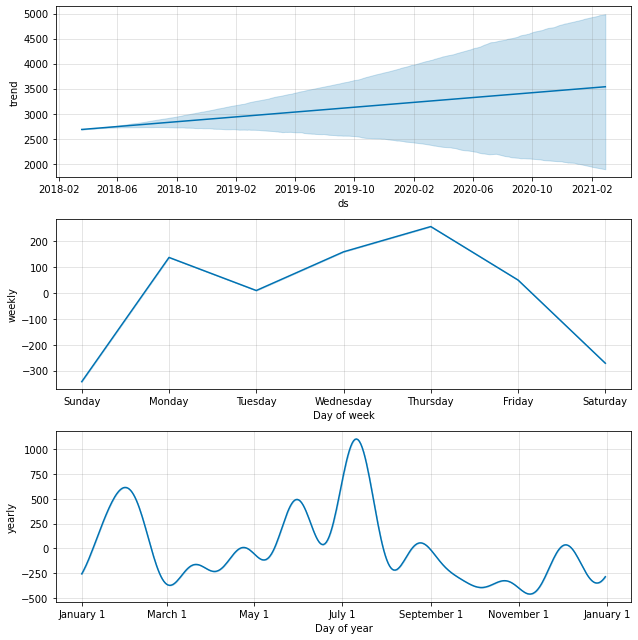

In [13]:
model_1.plot_components(forecast_1) 
plt.show()

**July** has the highest value

## 17. Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

In [14]:
# build multivariate forecast model
model_2 = Prophet()
model_2.add_regressor('SysLoad')
model_2.add_regressor('Tmax')
model_2.add_regressor('GasPrice')
model_2.fit(train)

Initial log joint probability = -4.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8218.46   0.000765413       377.196           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8219.42   0.000181158       126.613           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8219.72   0.000285842       78.9036           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       8219.78   7.57213e-05       255.214   4.419e-07       0.001      431  LS failed, Hessian reset 
     399       8219.86   1.51602e-05       76.2299      0.5333      0.5333      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     443       8219.87   8.26302e-07    

In [15]:
# evaluate mape
forecast_2 = model_2.predict(test) 
mape(test['y'],forecast_2['yhat'])

233.56

## 18. What is the RMSE in 2 decimal places?

In [16]:
# evaluate rmse
rmse(test['y'],forecast_2['yhat'])

2709.4

## 19.What day of the daily seasonality has the highest value?

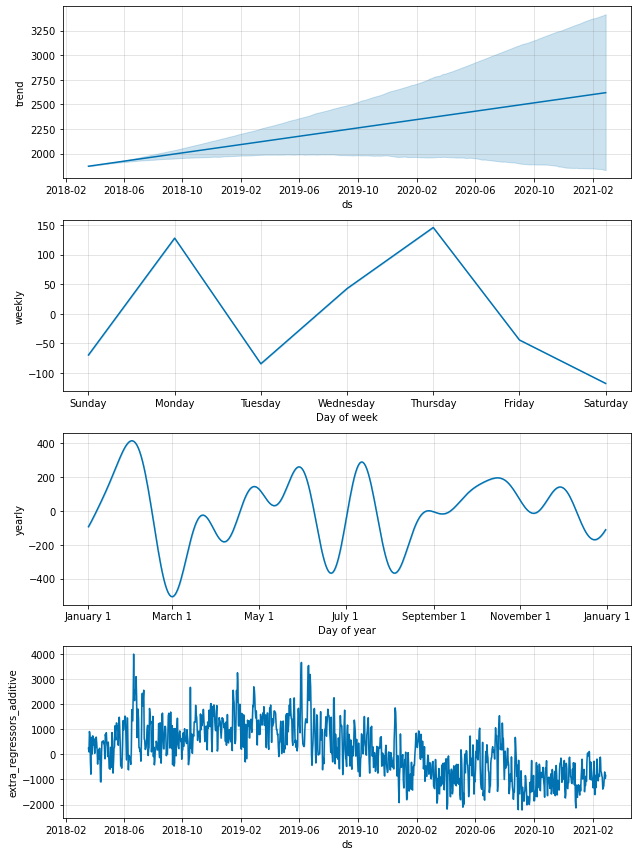

In [17]:
model_2.plot_components(forecast_2) 
plt.show()

**Thursday** has the highest value

## 20. What is the mean absolute percentage error (MAPE) to 2 decimal places on the test set?

In [18]:
# train a forecast model without 'Tmax'
model_3 = Prophet()
model_3.add_regressor('SysLoad')
model_3.add_regressor('GasPrice')
model_3.fit(train)

Initial log joint probability = -4.20632


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8218.62   0.000422017        94.239           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8219.39   5.87059e-05       77.0681        0.28           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8219.75   0.000787244       97.0431      0.7361      0.7361      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       8219.76   2.35034e-05       104.781   2.094e-07       0.001      409  LS failed, Hessian reset 
     380       8219.85   4.79102e-07       62.7508      0.2411           1      505   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [19]:
# evaluate mape
forecast_3 = model_3.predict(test) 
mape(test['y'],forecast_3['yhat'])

231.2